In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Load training and test data into dataframes
data_train = pd.read_csv('data/fashion-mnist_train.csv')
data_test = pd.read_csv('data/fashion-mnist_test.csv')

# X forms the training images, and y forms the training labels
X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))

# X_test forms the test images, and y_test forms the test labels
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

Using TensorFlow backend.


In [2]:
# Convert the training and test images into 3 channels
X = np.dstack([X] * 3)
X_test = np.dstack([X_test]*3)

# Display their new shapes
X.shape, X_test.shape

((60000, 784, 3), (9999, 784, 3))

In [3]:
# Reshape images as per the tensor format required by tensorflow
X = X.reshape(-1, 28,28,3)
X_test= X_test.reshape (-1,28,28,3)

# Display the new shape
X.shape, X_test.shape

((60000, 28, 28, 3), (9999, 28, 28, 3))

In [4]:
# Resize the images as 150 * 150 as required by VGG19
from keras.preprocessing.image import img_to_array, array_to_img

X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((150,150))) for im in X])
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((150,150))) for im in X_test])

# Display the new shape
X.shape, X_test.shape

((60000, 150, 150, 3), (10000, 150, 150, 3))

In [5]:
# Normalise the data and change data type
X = X.astype('float32')
X /= 255

X_test = X_test.astype('float32')
X_test /= 255

In [6]:
from sklearn.model_selection import train_test_split

# Here I split original training data to sub-training (80%) and validation data (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

# Check the data size whether it is as per tensorflow and VGG19 requirement
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((48000, 150, 150, 3), (12000, 150, 150, 3), (48000, 10), (12000, 10))

In [7]:
from keras.applications import VGG19

# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (150, 150, 3), classes = 10)

In [8]:
vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [9]:
from keras.applications.vgg19 import preprocess_input

# Preprocessing the input 
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [10]:
# Extracting features
train_features = vgg19.predict(np.array(X_train), batch_size=256, verbose=1)
test_features = vgg19.predict(np.array(X_test), batch_size=256, verbose=1)
val_features = vgg19.predict(np.array(X_val), batch_size=256, verbose=1)

12000/12000 [==============================] - 72s 6ms/step


In [11]:
# Saving the features so that they can be used for future
np.savez("train_features", train_features, y_train)
np.savez("test_features", test_features, y_test)
np.savez("val_features", val_features, y_val)

In [12]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

((48000, 4, 4, 512), '\n', (10000, 4, 4, 512), '\n', (12000, 4, 4, 512))


In [13]:
# Flatten extracted features
train_features = np.reshape(train_features, (48000, 4*4*512))
test_features = np.reshape(test_features, (10000, 4*4*512))
val_features = np.reshape(val_features, (12000, 4*4*512))

In [14]:
from keras.layers import Dense, Dropout
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers

# Add Dense and Dropout layers on top of VGG19 pre-trained
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

In [15]:
import keras

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [16]:
# Train the the model
history = model.fit(train_features, y_train,
          batch_size=256,
          epochs=50,
          verbose=1,
          validation_data=(val_features, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 3s 67us/step - loss: 1.9221 - acc: 0.3443 - val_loss: 1.3791 - val_acc: 0.6001
Epoch 2/50
48000/48000 [==============================] - 3s 56us/step - loss: 1.2921 - acc: 0.5343 - val_loss: 1.0462 - val_acc: 0.6325
Epoch 3/50
48000/48000 [==============================] - 3s 55us/step - loss: 1.1065 - acc: 0.6021 - val_loss: 0.9350 - val_acc: 0.6776
Epoch 4/50
48000/48000 [==============================] - 3s 56us/step - loss: 1.0226 - acc: 0.6267 - val_loss: 0.9029 - val_acc: 0.6947
Epoch 5/50
48000/48000 [==============================] - 3s 55us/step - loss: 0.9720 - acc: 0.6465 - val_loss: 0.8144 - val_acc: 0.6997
Epoch 6/50
48000/48000 [==============================] - 3s 55us/step - loss: 0.9393 - acc: 0.6546 - val_loss: 0.7923 - val_acc: 0.7165
Epoch 7/50
48000/48000 [==============================] - 3s 55us/step - loss: 0.9196 - acc: 0.6638 - val_loss: 0.7616 - val_acc

In [17]:
score = model.evaluate(test_features, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.6238402219772339)
('Test accuracy:', 0.7664)


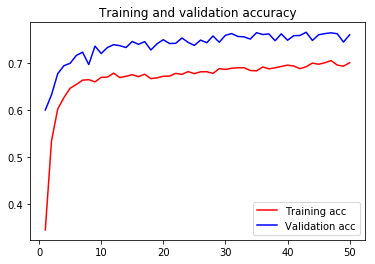

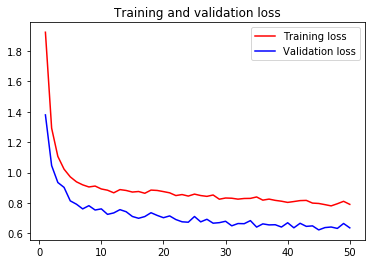

In [18]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [19]:
# get the predictions for the test data
predicted_classes = model.predict_classes(test_features)

# get the indices to be plotted
y_true = data_test.iloc[:, 0]
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [20]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.63      0.83      0.71      1000
    Class 1       0.94      0.95      0.95      1000
    Class 2       0.68      0.56      0.61      1000
    Class 3       0.81      0.79      0.80      1000
    Class 4       0.62      0.76      0.68      1000
    Class 5       0.77      0.95      0.85      1000
    Class 6       0.50      0.27      0.35      1000
    Class 7       0.89      0.77      0.82      1000
    Class 8       0.87      0.94      0.90      1000
    Class 9       0.91      0.85      0.88      1000

avg / total       0.76      0.77      0.76     10000



In [21]:
test_features[correct].shape

(7664, 8192)